<a href="https://colab.research.google.com/github/olgapoletkina/Deep-Learning-School-projects/blob/master/miptds2024/tn_hack/fine_tuning/vasily_metrics_plots_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.2/491.2 kB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 11.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 8.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 13.3 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; platform_system == 

In [2]:
!pip install -U sentence-transformers

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 340.6/340.6 kB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 54.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 33.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 34.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 79.2 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalli

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import pandas as pd
from random import sample
from sentence_transformers import InputExample # для создания текстовых пар с метками
from sentence_transformers import SentenceTransformer, losses
from torch.utils.data import DataLoader
import torch
from torch.utils.data import Dataset
from itertools import combinations
from sklearn.model_selection import GroupShuffleSplit # делим так чтобы группы не пересекались
from sklearn.metrics import precision_recall_curve, average_precision_score, f1_score
import numpy as np
# логи
from sentence_transformers import LoggingHandler
import logging

In [5]:
df = pd.read_excel("/content/drive/MyDrive/MFTI/SEM_02/Hackathon/results_with_dupes.xlsx")

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4394 entries, 0 to 4393
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Номер             4394 non-null   int64  
 1   Название          791 non-null    object 
 2   Описание          791 non-null    object 
 3   Статус            791 non-null    object 
 4   Номер_adj         791 non-null    float64
 5   Номер: Описание   791 non-null    object 
 6   Список номеров    178 non-null    object 
 7   Тип               178 non-null    object 
 8   Комментарий       178 non-null    object 
 9   Тематика          178 non-null    object 
 10  Номер_dupe        178 non-null    float64
 11  group_index       4394 non-null   int64  
 12  Описание_cleaned  4394 non-null   object 
 13  features          3603 non-null   object 
dtypes: float64(2), int64(2), object(10)
memory usage: 480.7+ KB


In [7]:
df = df[['Описание_cleaned', 'group_index']]
groups = df['group_index'].unique()
print(f"Всего групп: {len(groups)}")

Всего групп: 791


In [8]:
df

,Описание_cleaned,group_index
0,Ввести рейтинг заказчиков на roof.ru. Есть так...,2
1,"Проработать типовые узлы из 2д в 3д, основной ...",6
2,Добавить в ассортимент камешковую штукатурку с...,7
3,Ввести в ассортимент капельник самых распростр...,10
4,"На мешках и в нормативной документации, где у ...",15
...,...,...
4389,Оптимизировать состав клей-пены для утепления ...,798
4390,Изменить формулу клей-пены для XPS. Полиуретан...,798
4391,Совершенствовать рецептуру клей-пены для XPS. ...,798
4392,Модифицировать клей-пену для XPS. Применение п...,798


In [9]:
text_field = 'Описание_cleaned'

In [10]:
splitter = GroupShuffleSplit(test_size=0.2, n_splits=1, random_state=42)
train_idx, test_idx = next(splitter.split(df, groups=df['group_index']))

train_df = df.iloc[train_idx]
test_df = df.iloc[test_idx]

In [11]:
def create_examples(df):
    """Подбираем пары одинаковых/разных групп"""
    examples = []
    groups = df.groupby("group_index")[text_field].apply(list)

    for group_id, texts in groups.items():
        # Позитивные пары (одинаковый group_index)
        for i in range(len(texts)):
            for j in range(i + 1, len(texts)):
                examples.append(InputExample(texts=[texts[i], texts[j]], label=1.0))

        # Негативные пары: берём только часть случайных примеров из других групп
        # чтобы не получилось перекоса для каждой группы - десяток позитивных пар и тысяча негативных
        other_groups = [g for g in groups.items() if g[0] != group_id]
        other_texts_flat = [text for _, texts in other_groups for text in texts]

        # Берём 10 случайных негативных пар (чтобы не было перекоса в сторону негативных)
        for text in texts:
            for neg_text in sample(other_texts_flat, k=10):
                examples.append(InputExample(texts=[text, neg_text], label=0.0))

    return examples

In [12]:
train_examples = create_examples(train_df)
test_examples = create_examples(test_df)

print(f"Тренировочные пары: {len(train_examples)}")
print(f"Тестовые пары: {len(test_examples)}")

Тренировочные пары: 43209
Тестовые пары: 10894


In [14]:
def evaluate_model(model, examples, target_precision=None):
    similarities = []
    labels = []

    with torch.no_grad():  # Отключаем вычисление градиентов
        for example in examples:
            # Кодируем текст и сразу переносим на CPU, иначе будет падать
            emb1 = model.encode(example.texts[0], convert_to_tensor=True, show_progress_bar=False).cpu()
            emb2 = model.encode(example.texts[1], convert_to_tensor=True, show_progress_bar=False).cpu()
            emb1 = emb1.unsqueeze(0)
            emb2 = emb2.unsqueeze(0)

            # Вычисляем косинусную схожесть
            cos_sim = torch.nn.functional.cosine_similarity(emb1, emb2, dim=1).item()
            similarities.append(cos_sim)
            labels.append(example.label)

    # Преобразуем в numpy
    similarities = np.array(similarities)
    labels = np.array(labels)

    # Вычисляем метрики
    precision, recall, thresholds = precision_recall_curve(labels, similarities)
    # Подбираем оптимальный порог
    if target_precision is not None:
        # Ищем порог для заданной точности
        threshold_idx = np.where(precision[:-1] >= target_precision)[0]
        threshold = thresholds[threshold_idx[0]] if len(threshold_idx) > 0 else 0.5
    else:
        # Ищем порог с максимальным F1
        f1_scores = 2 * (precision[:-1] * recall[:-1]) / (precision[:-1] + recall[:-1] + 1e-8)
        threshold = thresholds[np.argmax(f1_scores)]

    pred_labels = similarities > threshold
    avg_precision = average_precision_score(labels, similarities)
    f1 = f1_score(labels, pred_labels)

    return {
        'average_precision': avg_precision,
        'f1_score': f1,
        'threshold': threshold,
        'precision': precision[:-1],
        'recall': recall[:-1],
        'thresholds': thresholds,
        'similarities': similarities
    }

In [15]:
# Загружаем обе модели
original_model = SentenceTransformer("cointegrated/rubert-tiny2")
fine_tuned_model = SentenceTransformer("/content/drive/MyDrive/MFTI/SEM_02/Hackathon/fine-tuned-rubert-tiny2")

# Оценка оригинальной модели
original_metrics = evaluate_model(original_model, test_examples)
print("Оригинальная модель:")
print(f"Оптимальный порог: {original_metrics['threshold']:.3f}")
print(f"F1: {original_metrics['f1_score']:.3f}")
print(f"Average Precision: {original_metrics['average_precision']:.3f}")

# Оценка дообученной модели
fine_tuned_metrics = evaluate_model(fine_tuned_model, test_examples)
print("\nДообученная модель:")
print(f"Оптимальный порог: {fine_tuned_metrics['threshold']:.3f}")
print(f"F1: {fine_tuned_metrics['f1_score']:.3f}")
print(f"Average Precision: {fine_tuned_metrics['average_precision']:.3f}")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/2.19k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/54.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/693 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/118M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/401 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/1.08M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.74M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Оригинальная модель:
Оптимальный порог: 0.771
F1: 0.967
Average Precision: 0.993

Дообученная модель:
Оптимальный порог: 0.457
F1: 0.976
Average Precision: 0.997


In [16]:
import matplotlib.pyplot as plt

def plot_pr_curves(original_metrics, fine_tuned_metrics):
    plt.figure(figsize=(8, 5))

    # Рисуем кривые Precision-Recall
    plt.plot(original_metrics['recall'], original_metrics['precision'],
             'b--', label=f'Исходная (AP={original_metrics["average_precision"]:.3f})')
    plt.plot(fine_tuned_metrics['recall'], fine_tuned_metrics['precision'],
             'r-', label=f'Дообученная (AP={fine_tuned_metrics["average_precision"]:.3f})')

    # Отмечаем точки оптимального F1
    plt.plot(original_metrics['recall'][np.argmax(original_metrics['precision'] + original_metrics['recall'])],
             original_metrics['precision'][np.argmax(original_metrics['precision'] + original_metrics['recall'])],
             'bo', markersize=8)

    plt.plot(fine_tuned_metrics['recall'][np.argmax(fine_tuned_metrics['precision'] + fine_tuned_metrics['recall'])],
             fine_tuned_metrics['precision'][np.argmax(fine_tuned_metrics['precision'] + fine_tuned_metrics['recall'])],
             'rx', markersize=8)

    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Сравнение Precision-Recall')
    plt.legend(loc='lower left')
    plt.grid(True, alpha=0.3)
    plt.xlim([0.85, 1])
    plt.ylim([0, 1.05])
    plt.tight_layout()
    plt.show()

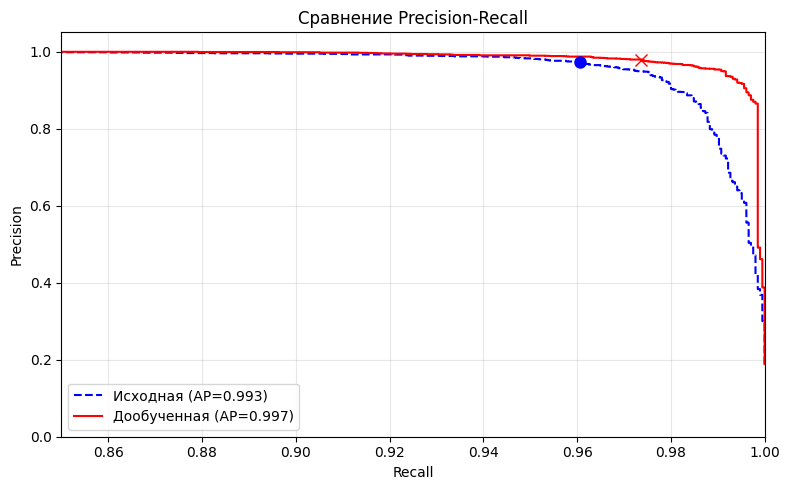

In [17]:
plot_pr_curves(original_metrics, fine_tuned_metrics)

Batches:   0%|          | 0/28 [00:00<?, ?it/s]

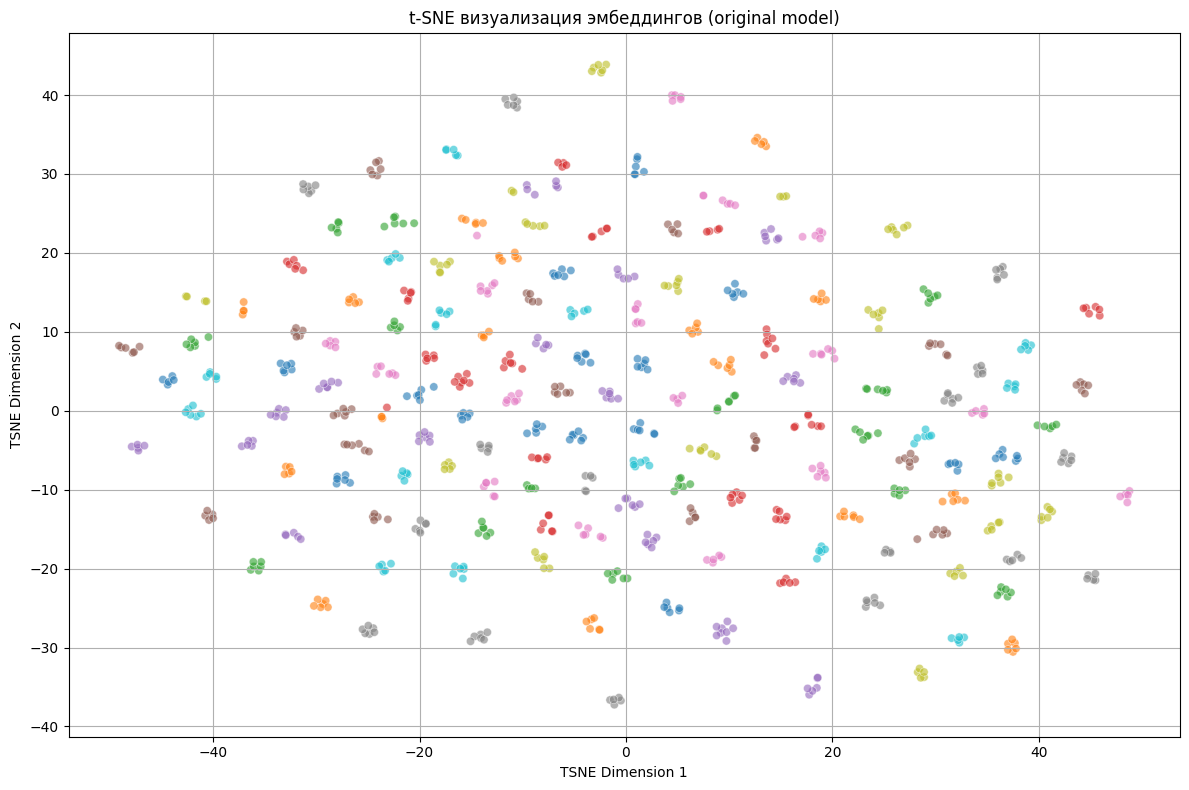

In [30]:
from sklearn.manifold import TSNE
import seaborn as sns

all_texts = list(set([ex.texts[0] for ex in test_examples] + [ex.texts[1] for ex in test_examples]))
all_labels = []

text_to_label = dict(zip(df[text_field], df['group_index']))
for text in all_texts:
    all_labels.append(text_to_label.get(text, -1))  # -1 если не найдено (на всякий случай)

embeddings = original_model.encode(all_texts, convert_to_tensor=False, show_progress_bar=True)

tsne = TSNE(n_components=2, perplexity=30, random_state=42)
X_tsne = tsne.fit_transform(embeddings)

tsne_df = pd.DataFrame({
    'TSNE_1': X_tsne[:, 0],
    'TSNE_2': X_tsne[:, 1],
    'group_index': all_labels
})

plt.figure(figsize=(12, 8))
sns.scatterplot(
    data=tsne_df,
    x='TSNE_1',
    y='TSNE_2',
    hue='group_index',
    palette='tab10',
    alpha=0.6,
    legend=False
)

plt.title("t-SNE визуализация эмбеддингов (original model)")
plt.xlabel("TSNE Dimension 1")
plt.ylabel("TSNE Dimension 2")
plt.grid(True)
plt.tight_layout()
plt.show()

## Метрики на дефолтной модели

`Silhouette Score` — близость внутри кластера vs отдалённость от других.

`Davies-Bouldin` — насколько кластеры различимы (↓ лучше).

`Calinski-Harabasz` — насколько хорошо отделены кластеры (↑ лучше).

In [31]:
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score

# Получаем метки кластеров (group_index) для каждого текста
text_to_label = dict(zip(df[text_field], df['group_index']))
labels = [text_to_label.get(text, -1) for text in all_texts]  # -1 если вдруг текста нет в словаре

# Преобразуем эмбеддинги в numpy-массив (если ещё не сделано)
embeddings_np = np.array(embeddings)

# Silhouette Score
sil_score = silhouette_score(embeddings_np, labels)
print(f"Silhouette Score: {sil_score:.3f}  ([-1, 1], ↑ лучше)")

#  Davies-Bouldin Index
db_index = davies_bouldin_score(embeddings_np, labels)
print(f"Davies-Bouldin Index: {db_index:.3f}  (↓ лучше)")

# Calinski-Harabasz Index
ch_index = calinski_harabasz_score(embeddings_np, labels)
print(f"Calinski-Harabasz Index: {ch_index:.3f}  (↑ лучше)")


Silhouette Score: 0.349  ([-1, 1], ↑ лучше)
Davies-Bouldin Index: 1.097  (↓ лучше)
Calinski-Harabasz Index: 14.987  (↑ лучше)


Batches:   0%|          | 0/28 [00:00<?, ?it/s]

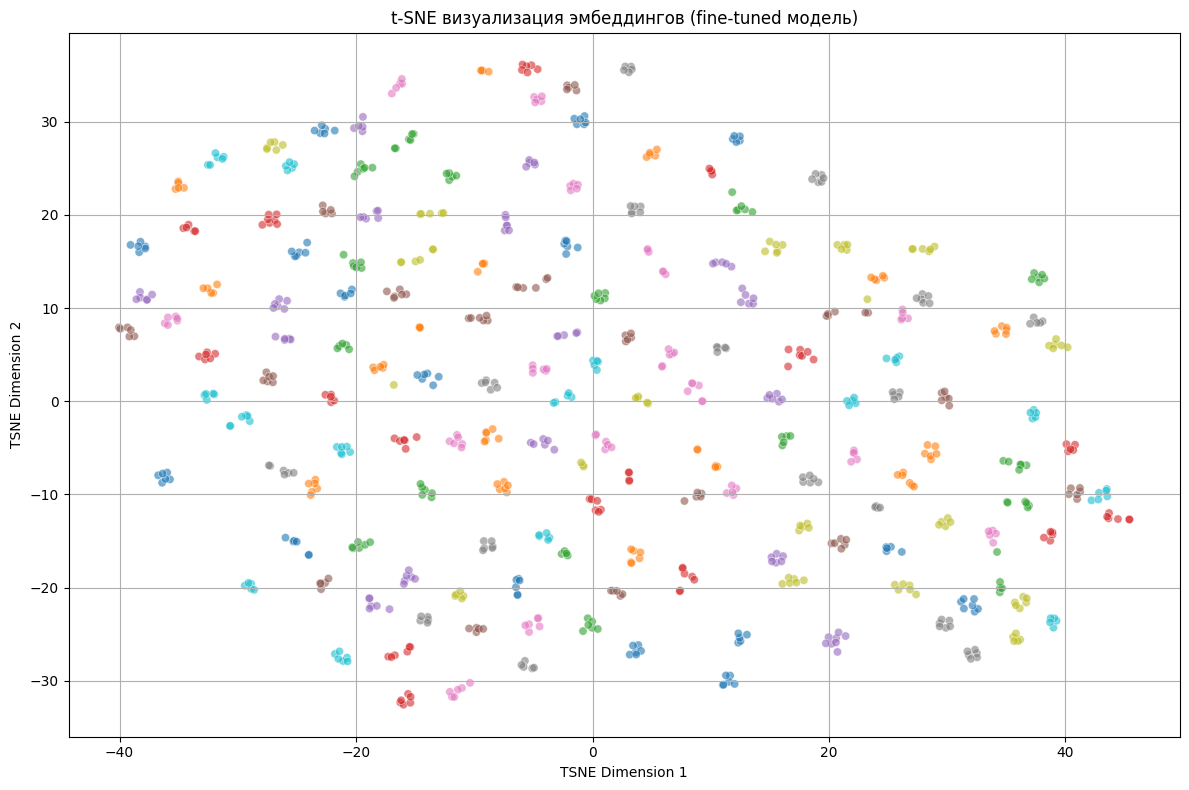

In [32]:
from sklearn.manifold import TSNE
import seaborn as sns

all_texts = list(set([ex.texts[0] for ex in test_examples] + [ex.texts[1] for ex in test_examples]))
all_labels = []

text_to_label = dict(zip(df[text_field], df['group_index']))
for text in all_texts:
    all_labels.append(text_to_label.get(text, -1))  # -1 если не найдено (на всякий случай)

embeddings = fine_tuned_model.encode(all_texts, convert_to_tensor=False, show_progress_bar=True)

tsne = TSNE(n_components=2, perplexity=30, random_state=42)
X_tsne = tsne.fit_transform(embeddings)

tsne_df = pd.DataFrame({
    'TSNE_1': X_tsne[:, 0],
    'TSNE_2': X_tsne[:, 1],
    'group_index': all_labels
})

plt.figure(figsize=(12, 8))
sns.scatterplot(
    data=tsne_df,
    x='TSNE_1',
    y='TSNE_2',
    hue='group_index',
    palette='tab10',
    alpha=0.6,
    legend=False
)

plt.title("t-SNE визуализация эмбеддингов (fine-tuned модель)")
plt.xlabel("TSNE Dimension 1")
plt.ylabel("TSNE Dimension 2")
plt.grid(True)
plt.tight_layout()
plt.show()


## Метрики на дообученной модели

In [33]:
text_to_label = dict(zip(df[text_field], df['group_index']))
labels = [text_to_label.get(text, -1) for text in all_texts]

embeddings_np = np.array(embeddings)

sil_score = silhouette_score(embeddings_np, labels)
print(f"Silhouette Score: {sil_score:.3f}  ([-1, 1], ↑ лучше)")

db_index = davies_bouldin_score(embeddings_np, labels)
print(f"Davies-Bouldin Index: {db_index:.3f}  (↓ лучше)")

ch_index = calinski_harabasz_score(embeddings_np, labels)
print(f"Calinski-Harabasz Index: {ch_index:.3f}  (↑ лучше)")

Silhouette Score: 0.430  ([-1, 1], ↑ лучше)
Davies-Bouldin Index: 0.948  (↓ лучше)
Calinski-Harabasz Index: 21.359  (↑ лучше)


## Метрики кластеризации: анализ качества модели

### Silhouette Score
- Показывает, насколько хорошо каждый эмбеддинг вписывается в свою группу по сравнению с другими.
- Диапазон значений: от -1 до 1. Чем ближе к 1 — тем лучше.
- Результаты:
  - До обучения: 0.349
  - После обучения: 0.430
- Вывод: прирост ~23% — эмбеддинги стали плотнее внутри своей группы и дальше от других.

### Davies-Bouldin Index
- Отражает среднюю схожесть между кластерами. Чем меньше значение — тем лучше (меньше перекрытия между кластерами).
- Результаты:
  - До обучения: 1.097
  - После обучения: 0.948
- Вывод: снижение на ~14% — кластеры стали более разделимыми.

### Calinski-Harabasz Index
- Отношение межкластерной дисперсии к внутрикластерной. Чем выше значение — тем лучше.
- Результаты:
  - До обучения: 14.987
  - После обучения: 21.359
- Вывод: рост ~42% — модель стала значительно лучше структурировать пространство эмбеддингов.

### Общий вывод
Дообученная модель перестроила латентное пространство так, что кластеры (группы) стали более чёткими, плотными и устойчивыми. Это особенно важно для задач поиска дубликатов, кластеризации и обработки больших объёмов неразмеченных данных.


In [21]:
big = pd.read_csv('/content/drive/MyDrive/MFTI/SEM_02/Hackathon/big.csv')

In [22]:
big.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1980326 entries, 0 to 1980325
Data columns (total 3 columns):
 #   Column        Dtype 
---  ------        ----- 
 0   text1         object
 1   text2         object
 2   is_dublicate  int64 
dtypes: int64(1), object(2)
memory usage: 45.3+ MB


In [23]:
big.head()

,text1,text2,is_dublicate
0,Ей идет это упражнение.,Она проходит через эти упражнения.,1
1,"Следит за обеспечением целостности, достоверно...","Гарантирует целостность, надёжность и сохранно...",1
2,Вэй Ин постоянно вытаскивал Ланя из привычной ...,Экскурсия поездом и на такси с российским гидо...,0
3,Можно не только на диодах.,Это возможно не только в диете.,1
4,"А развернулся и поспешно стал отходить, так чт...","Но он обернулся и стал торопливо переделывать,...",1


In [24]:
def evaluate_on_big(model, df, target_precision=None):
    similarities = []
    labels = []

    with torch.no_grad():
        for _, row in df.iterrows():
            emb1 = model.encode(row['text1'], convert_to_tensor=True).cpu()
            emb2 = model.encode(row['text2'], convert_to_tensor=True).cpu()
            cos_sim = torch.nn.functional.cosine_similarity(emb1.unsqueeze(0), emb2.unsqueeze(0)).item()

            similarities.append(cos_sim)
            labels.append(row['is_dublicate'])

    similarities = np.array(similarities)
    labels = np.array(labels)

    precision, recall, thresholds = precision_recall_curve(labels, similarities)

    # Выбор порога
    if target_precision:
        threshold_idx = np.where(precision[:-1] >= target_precision)[0]
        threshold = thresholds[threshold_idx[0]] if len(threshold_idx) > 0 else 0.5
    else:
        f1_scores = 2 * (precision[:-1] * recall[:-1]) / (precision[:-1] + recall[:-1] + 1e-8)
        threshold = thresholds[np.argmax(f1_scores)]

    pred_labels = similarities > threshold
    avg_precision = average_precision_score(labels, similarities)
    f1 = f1_score(labels, pred_labels)

    return {
        'average_precision': avg_precision,
        'f1_score': f1,
        'threshold': threshold,
        'precision': precision[:-1],
        'recall': recall[:-1],
        'thresholds': thresholds,
        'similarities': similarities,
        'true_labels': labels
    }


In [25]:
sampled_big = big.sample(n=10000, random_state=42)  # или n=int(len(big) * 0.1) для процента

big_original_metrics = evaluate_on_big(original_model, sampled_big)
big_finetuned_metrics = evaluate_on_big(fine_tuned_model, sampled_big)

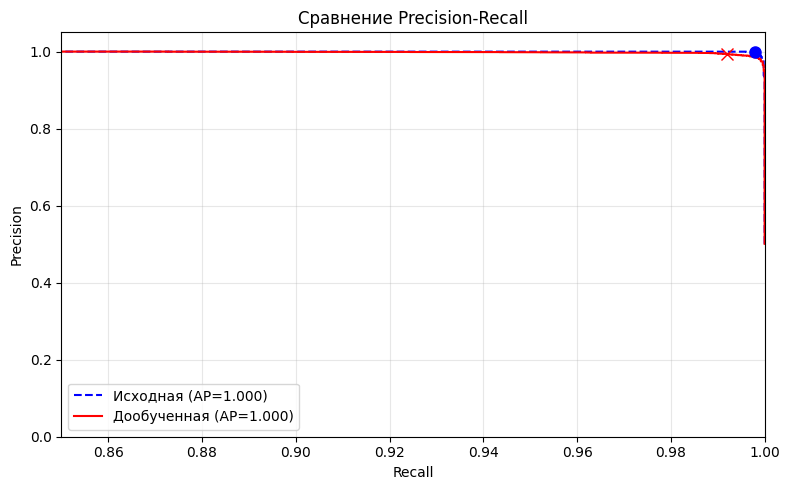

In [26]:
plot_pr_curves(big_original_metrics, big_finetuned_metrics)

In [27]:
print("Original model on BIG:")
print(f"F1 Score: {big_original_metrics['f1_score']:.3f}")
print(f"AP: {big_original_metrics['average_precision']:.3f}")
print(f"Threshold: {big_original_metrics['threshold']:.3f}")

print("\nFine-tuned model on BIG:")
print(f"F1 Score: {big_finetuned_metrics['f1_score']:.3f}")
print(f"AP: {big_finetuned_metrics['average_precision']:.3f}")
print(f"Threshold: {big_finetuned_metrics['threshold']:.3f}")

Original model on BIG:
F1 Score: 0.998
AP: 1.000
Threshold: 0.712

Fine-tuned model on BIG:
F1 Score: 0.993
AP: 1.000
Threshold: 0.548


In [28]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

def plot_roc_curves(original_metrics, fine_tuned_metrics):
    fpr_orig, tpr_orig, _ = roc_curve(original_metrics['true_labels'], original_metrics['similarities'])
    fpr_ft, tpr_ft, _ = roc_curve(fine_tuned_metrics['true_labels'], fine_tuned_metrics['similarities'])

    auc_orig = auc(fpr_orig, tpr_orig)
    auc_ft = auc(fpr_ft, tpr_ft)

    plt.figure(figsize=(8, 5))
    plt.plot(fpr_orig, tpr_orig, 'b--', label=f'Исходная (AUC={auc_orig:.3f})')
    plt.plot(fpr_ft, tpr_ft, 'r-', label=f'Дообученная (AUC={auc_ft:.3f})')

    plt.plot([0, 1], [0, 1], 'k--', lw=1, alpha=0.5)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC-кривая: сравнение моделей')
    plt.legend(loc='lower right')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

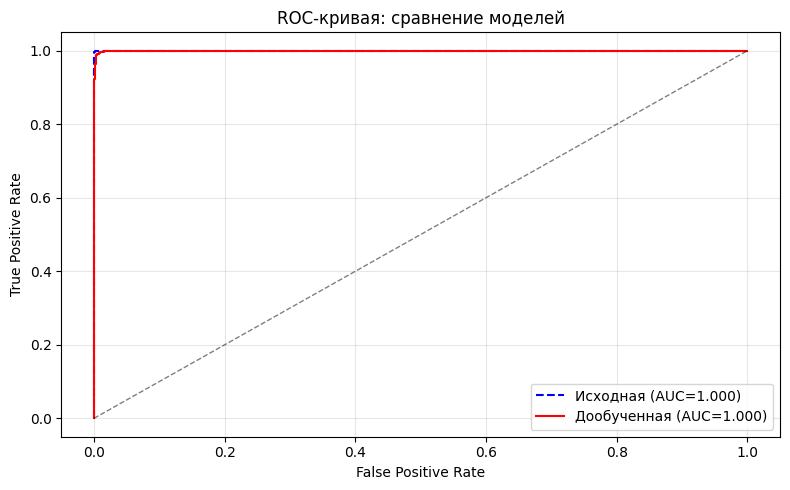

In [29]:
plot_roc_curves(big_original_metrics, big_finetuned_metrics)